# Multi Layer Perceptron (MLP)

> Simple feedforward Multilayer perceptron model

In [2]:
#| default_exp models.mlp

In [3]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [53]:
#| export
import torch.nn as nn
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from lightning import LightningModule, Trainer
from lightning.pytorch.tuner.tuning import Tuner
from lightning.pytorch.callbacks import LearningRateFinder
from lightning.pytorch.loggers import CSVLogger

from hydra.utils import instantiate
from omegaconf import OmegaConf
from matplotlib import pyplot as plt
import pandas as pd

from nimrod.utils import get_device
from nimrod.image.datasets import MNISTDataModule
from nimrod.models.core import Classifier
# torch.set_num_interop_threads(1)
# from IPython.core.debugger import set_trace

import logging
logger = logging.getLogger(__name__)

In [5]:
show_doc(MNISTDataModule)

---

[source](https://github.com/slegroux/nimrod/blob/main/nimrod/image/datasets.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### MNISTDataModule

>      MNISTDataModule (data_dir:str|os.PathLike='~/Data/',
>                       train_val_test_split:List[float]=[0.8, 0.1, 0.1],
>                       batch_size:int=64, num_workers:int=0,
>                       pin_memory:bool=False, persistent_workers:bool=False)

*Helper class that provides a standard way to create an ABC using
inheritance.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| data_dir | str \| os.PathLike | ~/Data/ | path to source data dir |
| train_val_test_split | List | [0.8, 0.1, 0.1] | train val test % |
| batch_size | int | 64 | size of compute batch |
| num_workers | int | 0 | num_workers equal 0 means that it’s the main process that will do the data loading when needed, num_workers equal 1 is the same as any n, but you’ll only have a single worker, so it might be slow |
| pin_memory | bool | False | If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, you can speed up the host to device transfer by enabling pin_memory. This lets your DataLoader allocate the samples in page-locked memory, which speeds-up the transfer |
| persistent_workers | bool | False |  |

## MLP

In [6]:
#| export
class MLP(nn.Module):
    def __init__(
                self,
                n_in:int=784, # input dimension e.g. (H,W) for image
                n_h:int=64, # hidden dimension
                n_out:int=10, # output dimension (= number of classes for classification)
                dropout:float=0.2
                ) -> None:
        logger.info("MLP: init")
        super().__init__()
        l1 = nn.Linear(n_in, n_h)
        dropout = nn.Dropout(dropout)
        relu = nn.ReLU()
        l2 = nn.Linear(n_h, n_out)
        self.layers = nn.Sequential(l1, dropout, relu, l2)
        
    def forward(self, x: torch.Tensor # dim (B, H*W)
                ) -> torch.Tensor:
        return self.layers(x)

### Usage

In [7]:
show_doc(MLP)

---

[source](https://github.com/slegroux/nimrod/blob/main/nimrod/models/mlp.py#L31){target="_blank" style="float:right; font-size:smaller"}

### MLP

>      MLP (n_in:int=784, n_h:int=64, n_out:int=10, dropout:float=0.2, **kwargs)

*Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__init__()`` call to the parent class
    must be made before assignment on the child.

:ivar training: Boolean represents whether this module is in training or
                evaluation mode.
:vartype training: bool*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| n_in | int | 784 | input dimension e.g. (H,W) for image |
| n_h | int | 64 | hidden dimension |
| n_out | int | 10 | output dimension (= number of classes for classification) |
| dropout | float | 0.2 |  |
| kwargs |  |  |  |
| **Returns** | **None** |  |  |

In [12]:
image = torch.rand((5, 28*28))
mlp = MLP(n_in=28*28, n_h=64, n_out=10, dropout=0.1)
out = mlp(image)
print(out.shape)
cfg = OmegaConf.load('../config/image/model/mlp.yaml')
model = instantiate(cfg.nnet)
out = model(image)
print(out.shape)

[22:39:47] INFO     [22:39:47]                                                                     ]8;id=627035;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_6382/3976215784.py\3976215784.py]8;;\:]8;id=161143;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_6382/3976215784.py#11\11]8;;\

torch.Size([5, 10])


           INFO     [22:39:47]                                                                            ]8;id=121515;file:///Users/slegroux/Projects/nimrod/nimrod/models/mlp.py\mlp.py]8;;\:]8;id=820614;file:///Users/slegroux/Projects/nimrod/nimrod/models/mlp.py#39\39]8;;\

torch.Size([5, 10])


### Training

In [13]:
# load from config file
cfg = OmegaConf.load('../config/image/data/mnist.yaml')
datamodule = instantiate(cfg.datamodule)
datamodule.prepare_data()
datamodule.setup()

x = datamodule.data_test[0][0] # (C, H, W)
print(len(datamodule.data_test))
label = datamodule.data_test[0][1] #(int)
print("original shape (C,H,W): ", x.shape)
print("reshape (C,HxW): ", x.view(x.size(0), -1).shape)
print(x[0][1])

[23:12:04] INFO     [23:12:04]                                                                      ]8;id=63883;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=906016;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#139\139]8;;\

           INFO     [23:12:04]                                                                       ]8;id=44437;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=782126;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#39\39]8;;\

           INFO     [23:12:04]                                                                       ]8;id=423250;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=825185;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#96\96]8;;\

           INFO     [23:12:04]                                                                       ]8;id=866776;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=764849;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#39\39]8;;\

           INFO     [23:12:04]                                                                       ]8;id=996612;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=889978;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#96\96]8;;\

           INFO     [23:12:04]                                                                       ]8;id=328061;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=498967;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#39\39]8;;\

           INFO     [23:12:04]                                                                       ]8;id=900189;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=828497;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#96\96]8;;\

           INFO     [23:12:04]                                                                       ]8;id=848588;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=626811;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#39\39]8;;\

           INFO     [23:12:04]                                                                       ]8;id=100470;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=306709;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#96\96]8;;\

7000
original shape (C,H,W):  torch.Size([1, 28, 28])
reshape (C,HxW):  torch.Size([1, 784])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


In [14]:
# using nimrod datamodule
train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()
test_loader = datamodule.test_dataloader()

In [23]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu" # for CI on cpu instance
device = torch.device(device)


#### Training loop

In [30]:
#| notest

%time
# data
cfg = OmegaConf.load('../config/image/data/mnist.yaml')
cfg.batch_size = 2048
datamodule = instantiate(cfg.datamodule)
datamodule.prepare_data()
datamodule.setup()

# model
model = mlp.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


n_epochs = 2
losses = []
lrs = []
current_step = 0
steps_per_epoch = len(datamodule.data_train) // cfg.datamodule.batch_size
total_steps = steps_per_epoch * n_epochs
print(f"steps_per_epoch: {steps_per_epoch}, total_steps: {total_steps}")

for epoch in range(n_epochs):
    model.train()
    for images, labels in datamodule.train_dataloader():
        optimizer.zero_grad()
        images = images.view(-1, 28*28)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        if not (current_step % 100):
            print(f"Loss {loss.item():.4f}, Current LR: {current_lr:.10f}, Step: {current_step}/{total_steps}")
        current_step += 1

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in datamodule.test_dataloader():
            # model expects input (B,H*W)
            images = images.view(-1, 28*28).to(device)
            images = images.to(device)
            labels = labels.to(device)
            # Pass the input through the model
            outputs = model(images)
            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update the total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum()

        # Print the accuracy
        print(f"Epoch {epoch + 1}: Accuracy = {100 * correct / total:.2f}%")


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 μs


[23:28:52] INFO     [23:28:52]                                                                      ]8;id=176180;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=879266;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#139\139]8;;\

           INFO     [23:28:52]                                                                       ]8;id=880467;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=599313;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#39\39]8;;\

           INFO     [23:28:52]                                                                       ]8;id=975396;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=367228;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#96\96]8;;\

           INFO     [23:28:52]                                                                       ]8;id=15034;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=311428;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#39\39]8;;\

           INFO     [23:28:52]                                                                       ]8;id=953960;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=708865;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#96\96]8;;\

           INFO     [23:28:52]                                                                       ]8;id=765732;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=681334;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#39\39]8;;\

           INFO     [23:28:52]                                                                       ]8;id=812010;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=977277;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#96\96]8;;\

           INFO     [23:28:52]                                                                       ]8;id=97200;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=413415;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#39\39]8;;\

           INFO     [23:28:52]                                                                       ]8;id=666238;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=608271;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#96\96]8;;\

steps_per_epoch: 875, total_steps: 1750
Loss 0.2762, Current LR: 0.0010000000, Step: 0/1750
Loss 0.3593, Current LR: 0.0010000000, Step: 100/1750
Loss 0.3040, Current LR: 0.0010000000, Step: 200/1750
Loss 0.5255, Current LR: 0.0010000000, Step: 300/1750
Loss 0.2393, Current LR: 0.0010000000, Step: 400/1750
Loss 0.5003, Current LR: 0.0010000000, Step: 500/1750
Loss 0.5182, Current LR: 0.0010000000, Step: 600/1750
Loss 0.4457, Current LR: 0.0010000000, Step: 700/1750
Loss 0.2864, Current LR: 0.0010000000, Step: 800/1750
Epoch 1: Accuracy = 91.06%
Loss 0.4490, Current LR: 0.0010000000, Step: 900/1750
Loss 0.4337, Current LR: 0.0010000000, Step: 1000/1750
Loss 0.3047, Current LR: 0.0010000000, Step: 1100/1750
Loss 1.0615, Current LR: 0.0010000000, Step: 1200/1750
Loss 0.4695, Current LR: 0.0010000000, Step: 1300/1750
Loss 0.2365, Current LR: 0.0010000000, Step: 1400/1750
Loss 0.5502, Current LR: 0.0010000000, Step: 1500/1750
Loss 0.4391, Current LR: 0.0010000000, Step: 1600/1750
Loss 0.334

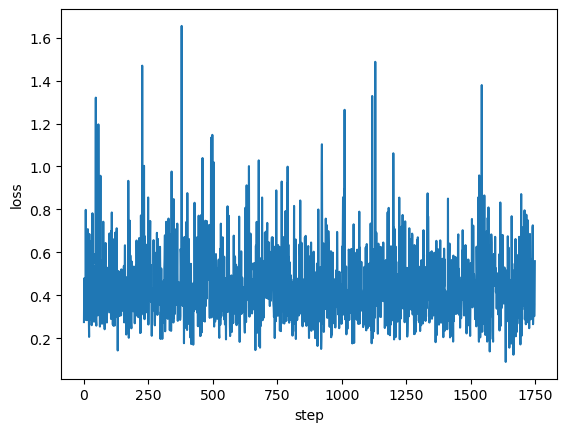

In [31]:
#| notest
# plt.figure(1)
# plt.subplot(211)
plt.ylabel('loss')
plt.xlabel('step')
plt.plot(losses)
# plt.subplot(212)
# plt.ylabel('lr')
# plt.xlabel('step')
# plt.plot(lrs)

## MLP_X

In [41]:
#| export

class MLP_X(Classifier, LightningModule):
    def __init__(
            self,
            nnet:MLP,
            num_classes:int,
            optimizer:torch.optim.Optimizer,
            scheduler:torch.optim.lr_scheduler
        ):
        
        logger.info("MLP_X init")
        super().__init__(num_classes, optimizer, scheduler)
        self.nnet = nnet
        self.save_hyperparameters(logger=False,ignore=['nnet'])
        self.lr = optimizer.keywords['lr'] # for lr finder
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnet(x)
    
    def _step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        preds = y_hat.argmax(dim=1)
        return loss, preds, y
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self.forward(x)
        return y_hat.argmax(dim=1)

### Usage

In [44]:
cfg = OmegaConf.load('../config/image/model/mlp.yaml')
model = instantiate(cfg)
b = torch.rand((16,1, 28*28))
y = model(b)
print(y.shape)

[23:40:58] INFO     [23:40:58]                                                                            ]8;id=937291;file:///Users/slegroux/Projects/nimrod/nimrod/models/mlp.py\mlp.py]8;;\:]8;id=121617;file:///Users/slegroux/Projects/nimrod/nimrod/models/mlp.py#39\39]8;;\

           INFO     [23:40:58]                                                                            ]8;id=103339;file:///Users/slegroux/Projects/nimrod/nimrod/models/mlp.py\mlp.py]8;;\:]8;id=421908;file:///Users/slegroux/Projects/nimrod/nimrod/models/mlp.py#61\61]8;;\

           INFO     [23:40:58]                                                                           ]8;id=321171;file:///Users/slegroux/Projects/nimrod/nimrod/models/core.py\core.py]8;;\:]8;id=248914;file:///Users/slegroux/Projects/nimrod/nimrod/models/core.py#35\35]8;;\

torch.Size([16, 1, 10])


### Nimrod training

In [45]:
# model
cfg = OmegaConf.load('../config/image/model/conv.yaml')
model = instantiate(cfg)

# data module config
cfg = OmegaConf.load('../config/image/data/mnist.yaml')
cfg.datamodule.batch_size = 2048
cfg.datamodule.num_workers = 0
datamodule = instantiate(cfg.datamodule)
# datamodule.prepare_data()
datamodule.setup()

[23:42:28] INFO     [23:42:28]                                                                           ]8;id=93102;file:///Users/slegroux/Projects/nimrod/nimrod/models/conv.py\conv.py]8;;\:]8;id=232989;file:///Users/slegroux/Projects/nimrod/nimrod/models/conv.py#91\91]8;;\

           INFO     [23:42:28]                                                                           ]8;id=831430;file:///Users/slegroux/Projects/nimrod/nimrod/models/core.py\core.py]8;;\:]8;id=684064;file:///Users/slegroux/Projects/nimrod/nimrod/models/core.py#35\35]8;;\

           INFO     [23:42:28]                                                                      ]8;id=371247;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=632945;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#139\139]8;;\

           INFO     [23:42:28]                                                                       ]8;id=603868;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=974264;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#39\39]8;;\

           INFO     [23:42:28]                                                                       ]8;id=549472;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=372032;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#96\96]8;;\

           INFO     [23:42:28]                                                                       ]8;id=486203;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=306764;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#39\39]8;;\

           INFO     [23:42:28]                                                                       ]8;id=52394;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py\datasets.py]8;;\:]8;id=294973;file:///Users/slegroux/Projects/nimrod/nimrod/image/datasets.py#96\96]8;;\

In [50]:
trainer = Trainer(
    accelerator="auto",
    max_epochs=3,
    logger=CSVLogger("logs", name="mnist_mlp")
    )


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [51]:
#| notest
trainer.fit(model, datamodule.train_dataloader(), datamodule.val_dataloader())


  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | loss         | CrossEntropyLoss   | 0      | train
1 | train_acc    | MulticlassAccuracy | 0      | train
2 | val_acc      | MulticlassAccuracy | 0      | train
3 | test_acc     | MulticlassAccuracy | 0      | train
4 | train_loss   | MeanMetric         | 0      | train
5 | val_loss     | MeanMetric         | 0      | train
6 | test_loss    | MeanMetric         | 0      | train
7 | val_acc_best | MaxMetric          | 0      | train
8 | nnet         | ConvNet            | 30.5 K | train
------------------------------------------------------------
30.5 K    Trainable params
0         Non-trainable params
30.5 K    Total params
0.122     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


tensor(2.3042, device='mps:0')
tensor(2.3040, device='mps:0')


/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

tensor(2.6542, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(2.1259, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.7632, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.4998, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.3627, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.2666, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.1640, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.0932, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.0598, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.0151, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.9836, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.9786, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.9298, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.9174, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.8866, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.8691, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.8562, device='mps:0', grad_fn=<NllLossBackward0

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(1.5506, device='mps:0')
tensor(1.5569, device='mps:0')
tensor(1.5453, device='mps:0')
tensor(1.5527, device='mps:0')
tensor(0.6944, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6827, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6770, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6595, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6598, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6453, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6510, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6345, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6189, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6236, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6216, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.5975, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6196, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6024, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.5831, device='mps:0', grad_fn=<NllLossBac

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.5937, device='mps:0')
tensor(0.6125, device='mps:0')
tensor(0.5952, device='mps:0')
tensor(0.6018, device='mps:0')
tensor(0.5190, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.5098, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.5290, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.4995, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.5051, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.5048, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.4921, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.4820, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.4731, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.4956, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.4779, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.4741, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.4845, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.4680, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.4700, device='mps:0', grad_fn=<NllLossBac

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.4273, device='mps:0')
tensor(0.4365, device='mps:0')
tensor(0.4312, device='mps:0')


`Trainer.fit` stopped: `max_epochs=3` reached.


tensor(0.4288, device='mps:0')


In [54]:
#| notest
csv_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(csv_path)
metrics.head(5)

,epoch,step,train/acc_epoch,train/acc_step,train/loss_epoch,train/loss_step,val/acc,val/acc_best,val/loss
0,0,27,NaN,NaN,NaN,NaN,0.615571,0.615571,1.551375
1,0,27,0.745143,NaN,1.065502,NaN,NaN,NaN,NaN
2,1,49,NaN,0.930664,NaN,0.558403,NaN,NaN,NaN
3,1,55,NaN,NaN,NaN,NaN,0.938429,0.938429,0.600814
4,1,55,0.919500,NaN,0.598742,NaN,NaN,NaN,NaN


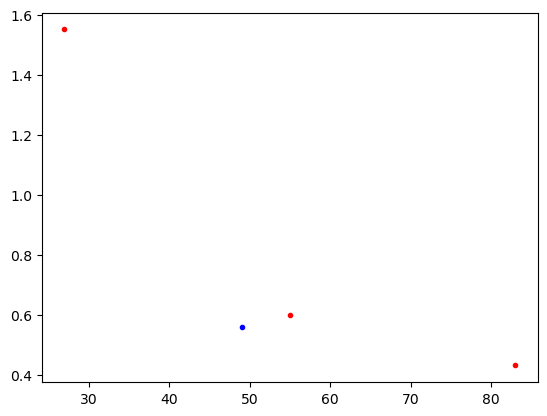

In [55]:
#| notest
plt.figure()
plt.plot(metrics['step'], metrics['train/loss_step'], 'b.-')
plt.plot(metrics['step'], metrics['val/loss'],'r.-')
plt.show()

In [57]:
#| notest
trainer.test(model, datamodule.test_dataloader())

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

tensor(0.4353, device='mps:0')
tensor(0.4417, device='mps:0')
tensor(0.4415, device='mps:0')
tensor(0.4340, device='mps:0')


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9584285616874695     │
│         test/loss         │    0.4381471276283264     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.4381471276283264, 'test/acc': 0.9584285616874695}]

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()